# 參數設定(VMD + 未使用訊號分解)

In [1]:
import os

labels = ['GroupCount']
model_type = 2 # 使用模型
predicteds = [5] # 預測類別 
batch_size = 14  # 批次大小

# labels = ['GroupCount']
# model_type = 1 # 使用模型
# predicteds = [1] # 預測類別 
# batch_size = 14  # 批次大小


# ==== 底下的參數基本上都不要亂動 ====
past_day = 14  # 過去天數，用於訓練資料中的歷史資料長度
future_day = 1
vmd_k = 8 # VMD分解層數
std_num = 1 # 標準差倍數
sigma = 1

train_split_rate = 0.8  # 訓練集佔整體資料集的比例
val_split_rate = 0.1 # 驗證集占整體資料集的比例
  
model_dir = 'VMD_NoDecomp/_Model'

# 定義類別

In [2]:
import joblib

# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import LstmLib 
importlib.reload(LstmLib)   

from LstmLib import * 
lstm = LstmLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
x_scaler_file_name, y_scaler_file_name, model_file_name, result_file_name = \
    lstm.reset_data(model_dir, labels, model_type, predicteds, batch_size)

x_scaler_file_name: VMD_NoDecomp/_Model/GroupCount_mt2_data5_batch14.x_scaler.pkl
y_scaler_file_name: VMD_NoDecomp/_Model/GroupCount_mt2_data5_batch14.y_scaler.pkl
model_file_name: VMD_NoDecomp/_Model/GroupCount_mt2_data5_batch14.model.keras
result_file_name: VMD_NoDecomp/_Model/GroupCount_mt2_data5_batch14.result.json


# 載入數據

In [4]:
df_source = lstm.load_data(predicteds)

print(len(df_source))
df_source.head()

# 載入數據
395


,RequestTime,Predicted,SendBytes,ReceiveBytes,TimeTaken,UrlType1,UrlType2,UrlType3,Method_GET,Method_POST,Method_PUT,Method_DELETE,Method_HEAD,Method_OPTIONS,Method_PATCH,GroupCount
0,2023-04-02,[5],156009964,1063367,873569,9,2531,64,2604,0,0,0,0,0,0,2604
1,2023-04-03,[5],266983699,1670644,1289435,33,3928,75,4034,2,0,0,0,0,0,4036
2,2023-04-04,[5],198064713,1377806,881103,8,3552,72,3630,2,0,0,0,0,0,3632
3,2023-04-05,[5],275355693,1804631,1005218,8,4270,101,4378,1,0,0,0,0,0,4379
4,2023-04-06,[5],226168175,2059599,1254506,40,5491,82,5612,0,0,0,1,0,0,5613


# VMD 訊號分解

In [5]:
data_source = df_source[labels].values
u = lstm.vmd_decomposition(data_source, K = vmd_k)

print(data_source.shape)
print(u.shape)  

(395, 1)
(8, 394)


# 繪製 VMD 訊號分解圖

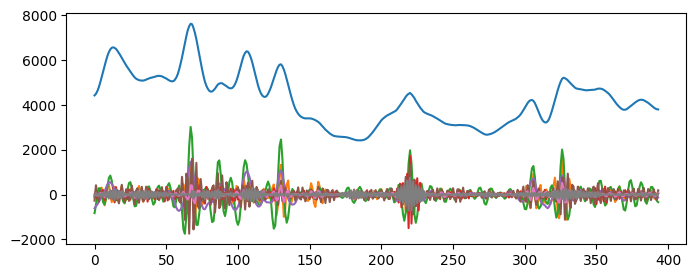

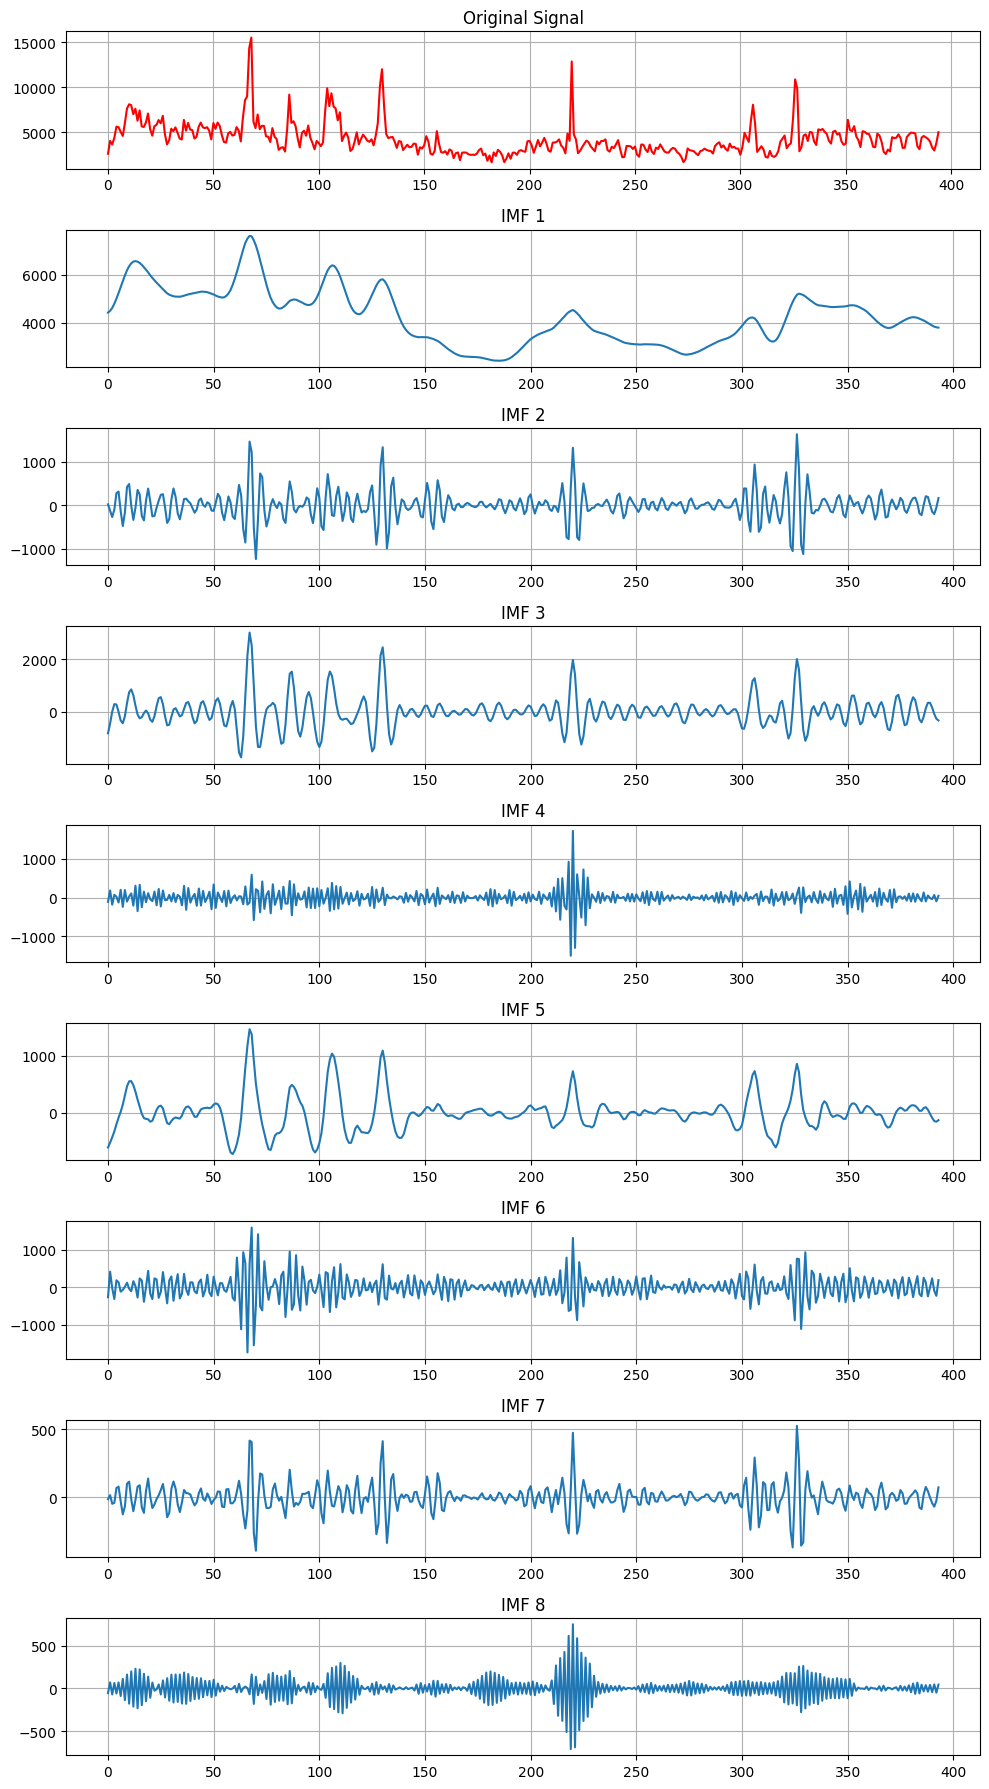

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(u.T)  
plt.show()

lstm.plot_imfs_with_original(data_source, u) 

# VMD 異常資料前處理

IMFs 的數量: 8, 每個 IMF 的長度: 394
將異常部分的值進行平滑處理，imf 1 有 125 個異常點
將異常部分的值進行平滑處理，imf 2 有 80 個異常點
將異常部分的值進行平滑處理，imf 3 有 74 個異常點
將異常部分的值進行平滑處理，imf 4 有 72 個異常點
將異常部分的值進行平滑處理，imf 5 有 88 個異常點
將異常部分的值進行平滑處理，imf 6 有 72 個異常點
將異常部分的值進行平滑處理，imf 7 有 69 個異常點
將異常部分的值進行平滑處理，imf 8 有 94 個異常點
(394,)
(394,)
(394,)
MAE: 312.2919
MAPE: 0.0609


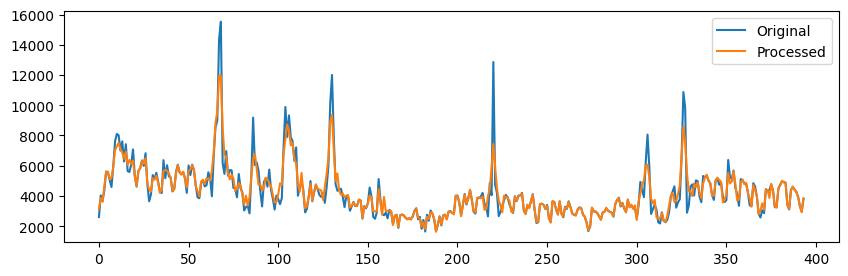

In [7]:
processed_signal = lstm.preprocess_smooth_signal_imfs(u, sigma=sigma, std_threshold=std_num)
original_signal = np.sum(u, axis=0)
# VMD 分解後會少最後一個值，因此要把原始資料的最後一個值去掉
original_data = data_source[:-1].reshape(-1)

print(original_data.shape)
print(processed_signal.shape) 
print(original_signal.shape)

mae = mean_absolute_error(original_data, processed_signal)
mape = mean_absolute_percentage_error(original_signal, processed_signal)

print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')

plt.figure(figsize=(10, 3))
plt.plot(data_source[:-1], label='Original') 
plt.plot(processed_signal, label='Processed')
plt.legend()
plt.show() 

# 最小最大正規化

In [8]:
x_norm, y_norm, x_scaler, y_scaler = \
    lstm.normalize_by_decomposition(processed_signal, x_scaler = None, y_scaler = None);

joblib.dump(x_scaler, x_scaler_file_name)
joblib.dump(y_scaler, y_scaler_file_name)
print('儲存最小最大縮放參數')

# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數


# 切割訓練、驗證和測試資料集

In [9]:
x_train, y_train, x_val, y_val, x_test, y_test = \
    lstm.train_val_test_split(
        x_norm,
        train_split_rate = train_split_rate,
        val_split_rate = val_split_rate
    )

# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)


# 將資料轉成 LSTM 模型所需資料格式(三維)

In [10]:
# 訓練集
x_lstm_train, y_lstm_train, _ = \
    lstm.reshape_data_for_lstm(
        x_train, y_train,
        date_array = None,
        past_day = past_day,
        future_day = future_day
    )
print('====== Train DataSet ======')
print('訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) :', x_lstm_train.shape)
print('訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) :', y_lstm_train.shape)

# 驗證集
x_lstm_val, y_lstm_val, _ = \
    lstm.reshape_data_for_lstm(
        x_val, y_val,
        date_array = None,
        past_day = past_day,
        future_day = future_day
    )
print('====== Val DataSet ======')
print('驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) :', x_lstm_val.shape)
print('驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) :', y_lstm_val.shape)

# 測試集
x_lstm_test, y_lstm_test, _ = \
    lstm.reshape_data_for_lstm(
        x_test, y_test,
        date_array = None,
        past_day = past_day,
        future_day = future_day
    )
print('====== Test DataSet ======')
print('測試集 : x_lstm_test (筆數, 天數, 特徵數) :', x_lstm_test.shape)
print('測試集 : y_lstm_test (筆數, 天數, 標籤數) :', y_lstm_test.shape)

# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (300, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) : (24, 14, 1)
驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) : (24, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Test DataSet ======
測試集 : x_lstm_test (筆數, 天數, 特徵數) : (25, 14, 1)
測試集 : y_lstm_test (筆數, 天數, 標籤數) : (25, 1)


# 定義 Model

In [11]:
# 定義 Model
model = lstm.build_model(
    model_type = model_type,
    time_step = past_day,
    n_predictions = future_day
)

# 定義 Model：2
BiLSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 200)                 │          81,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │          30,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,551 (525.59 KB)

 Trainable params: 134,551 (525.59 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練

In [12]:
train_history = lstm.model_fit(
    model = model,
    batch_size = batch_size,
    x_train = x_lstm_train,
    y_train = y_lstm_train,
    x_val = x_lstm_val,
    y_val = y_lstm_val,
)

# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


# 儲存模型

In [13]:
model.save(model_file_name)
print(f'儲存模型到 {model_file_name}')

儲存模型到 VMD_NoDecomp/_Model/GroupCount_mt2_data5_batch14.model.keras


# 預測

In [14]:
predict_train = lstm.predict(model, x_lstm_train)
print(f'預測 train.shape : {predict_train.shape}')

predict_val = lstm.predict(model, x_lstm_val)
print(f'預測 val.shape : {predict_val.shape}')

predict_test = lstm.predict(model, x_lstm_test)
print(f'預測 test.shape : {predict_test.shape}')

# 預測
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)


# 回復預測資料值為原始數據的規模

In [15]:
# 訓練
predict_inverse_train, actual_inverse_train, predict_train, actual_train = \
    lstm.denormalize_and_reshape_back(
        y_predict = predict_train,
        y_lstm_actual = y_lstm_train,
        y_scaler = y_scaler,
        n_predictions = future_day
    )

# 驗證
predict_inverse_val, actual_inverse_val, predict_val, actual_val = \
    lstm.denormalize_and_reshape_back(
        y_predict = predict_val,
        y_lstm_actual = y_lstm_val,
        y_scaler = y_scaler,
        n_predictions = future_day
    )

# 測試
predict_inverse_test, actual_inverse_test, predict_test, actual_test = \
    lstm.denormalize_and_reshape_back(
        y_predict = predict_test,
        y_lstm_actual = y_lstm_test,
        y_scaler = y_scaler,
        n_predictions = future_day
    )

# 回復預測資料值為原始數據的規模
# 回復預測資料值為原始數據的規模
# 回復預測資料值為原始數據的規模


# 查看訓練 & 驗證 & 測試集評估數據

In [16]:
# 查看訓練 & 驗證 & 測試集評估數據
print('\033[93m# 查看訓練 & 驗證 & 測試集評估數據\x1b[0m')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31mTrain Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
lstm.evaluation(model, x_lstm_train, y_lstm_train)
print('--- 訓練值比較 --- ')
lstm.score(actual_train, predict_train)
print('--- 原始值比較 --- ')
mae_train, mape_train = lstm.score(actual_inverse_train, predict_inverse_train)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31mVal Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
lstm.evaluation(model, x_lstm_val, y_lstm_val)
print('--- 正規化比較 --- ')
lstm.score(actual_val, predict_val)
print('--- 原始值比較 --- ')
mae_val, mape_val = lstm.score(actual_inverse_val, predict_inverse_val)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31mTest Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
evaluations = lstm.evaluation(model, x_lstm_test, y_lstm_test)
print('--- 正規化比較 --- ')
lstm.score(actual_test, predict_test)
print('--- 原始值比較 --- ')
mae_test, mape_test = lstm.score(actual_inverse_test, predict_inverse_test)
print('')

# 查看訓練 & 驗證 & 測試集評估數據
------------------------------------------------------------------------
Train Evaluate
------------------------------------------------------------------------
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - mean_absolute_percentage_error: 18.1017

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - mean_absolute_percentage_error: 194182.5938


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.0679，MAPE:1351785256059.2178，MSE:0.00957，RMSE:0.09781，R square:0.59311
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:701.57099，MAPE:0.16115，MSE:1021400.01232，RMSE:1010.64337，R square:0.59311

------------------------------------------------------------------------
Val Evaluate
------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - mean_absolute_percentage_error: 22.7584

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - mean_absolute_percentage_error: 22.7584


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.06579，MAPE:0.22758，MSE:0.00604，RMSE:0.0777，R square:-1.16155
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:679.71721，MAPE:0.14577，MSE:644567.34318，RMSE:802.84951，R square:-1.16155

------------------------------------------------------------------------
Test Evaluate
------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0059 - mean_absolute_percentage_error: 31.5158

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0059 - mean_absolute_percentage_error: 31.5158


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.06817，MAPE:0.31516，MSE:0.00585，RMSE:0.07651，R square:-0.42269
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:704.36009，MAPE:0.17802，MSE:624919.48341，RMSE:790.51849，R square:-0.42269



# 顯示原始數據圖表

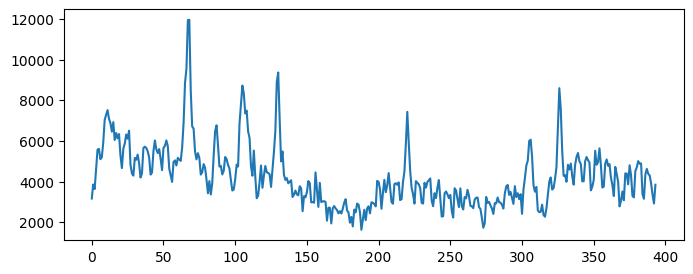

In [17]:
plt.figure(figsize=(8, 3))
plt.plot(processed_signal)
plt.show()

## 載入原始數據切割成 LSTM 格式的區段

In [18]:
# 這邊只是為了驗證數據的正確性
x_train_origin, y_train_origin, x_val_origin, y_val_origin, x_test_origin, y_test_origin = \
    lstm.train_val_test_split(
        processed_signal,
        train_split_rate = train_split_rate,
        val_split_rate = val_split_rate
    )

# 切割訓練、驗證和測試資料集
x_train.shape: (315,)
y_train.shape: (315,)
x_val.shape: (39,)
y_val.shape: (39,)
x_test.shape: (40,)
y_test.shape: (40,)


## 訓練集

原始資料 (315,)
[2493.65877498 2513.20791131 2862.28812355]
還原原始資料 (300, 1)
[[2513.20791131]
 [2862.28812355]]


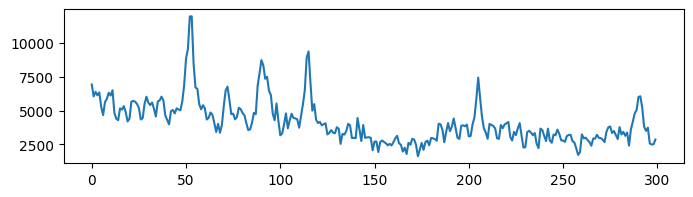

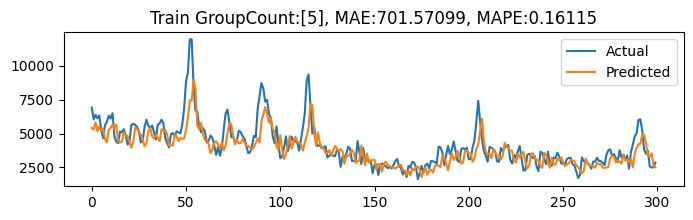

In [19]:
print('原始資料' , y_train_origin.shape)
print(y_train_origin[-3:])

print('還原原始資料', actual_inverse_train.shape)
print(actual_inverse_train[-2:])

lstm.show_predict_chart(
    actual = actual_inverse_train,
    predict = predict_inverse_train,
    title = f'Train {labels[0]}:{predicteds}, MAE:{round(mae_train, 5)}, MAPE:{round(mape_train, 5)}'
)

## 驗證集

原始資料 (39,)
[5514.9731393  4827.39957884 4958.91215016]
還原原始資料 (24, 1)
[[4827.39957884]
 [4958.91215016]]


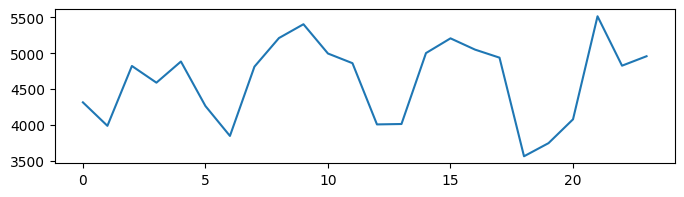

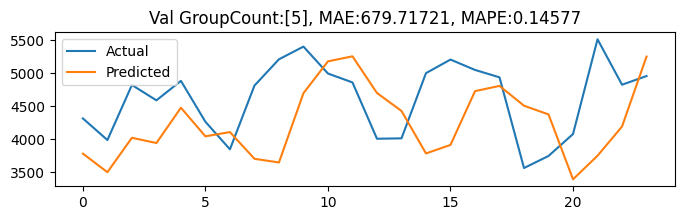

In [20]:
print('原始資料' , y_val_origin.shape)
print(y_val_origin[-3:])

print('還原原始資料', actual_inverse_val.shape)
print(actual_inverse_val[-2:])

lstm.show_predict_chart(
    actual = actual_inverse_val,
    predict = predict_inverse_val,
    title = f'Val {labels[0]}:{predicteds}, MAE:{round(mae_val, 5)}, MAPE:{round(mape_val, 5)}'
)

## 測試集

原始資料 (40,)
[3344.23380158 2919.08384103 3844.03124162]
還原原始資料 (25, 1)
[[2919.08384103]
 [3844.03124162]]
Test GroupCount:[5], BatchSize:14, MAE:704.36009, MAPE:0.17802


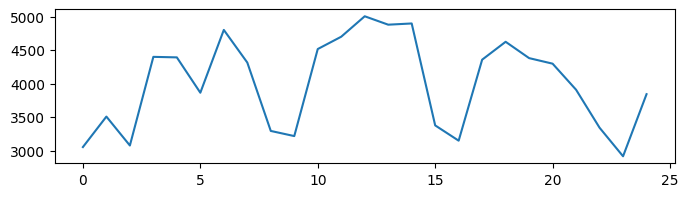

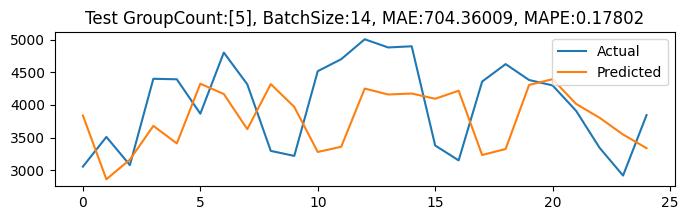

In [21]:
print('原始資料' , y_test_origin.shape)
print(y_test_origin[-3:])

print('還原原始資料', actual_inverse_test.shape)
print(actual_inverse_test[-2:])

title = f'Test {labels[0]}:{predicteds}, BatchSize:{batch_size}, MAE:{round(mae_test, 5)}, MAPE:{round(mape_test, 5)}'

print(title)
lstm.show_predict_chart(
    actual = actual_inverse_test,
    predict = predict_inverse_test,
    title = title
)

# 儲存結果

In [22]:
lstm.save_json_file(
    result_file_name, model_dir, labels, model_type, predicteds, 
    batch_size, mae_train, mape_train, mae_test, mape_test,
    kfold = None
)

{'type': 'VMD_NoDecomp', 'labels': ['GroupCount'], 'model_type': 2, 'predicteds': [5], 'batch_size': 14, 'train_mae': 701.57099, 'train_mape': 0.16115, 'test_mae': 704.36009, 'test_mape': 0.17802, 'kfold': None, 'imfs': None}
儲存評估結果到 VMD_NoDecomp/_Model/GroupCount_mt2_data5_batch14.result.json
